In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import os
from pathlib import Path
import re

In [71]:
def plot_cdf(data, bins_count):
    count, bins_count = np.histogram(data, bins=bins_count)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    plt.plot(bins_count[1:], pdf, color="red", label="PDF")
    plt.plot(bins_count[1:], cdf, label="CDF")
    plt.legend()
def is_float(string):
    try:
        float(string)
        return True
    except ValueError:
        return False
def get_data(compiler_name, if_long):
    data = []
    if(if_long):
        trace = 'tracefiles_long'
    else:
        trace = 'tracefile'
    path = Path(f'../optimizations/{compiler_name}/{trace}')
    print('path: ', path)
    contracts = [f for f in path.iterdir() if f.is_dir()]
    for contract in contracts:
        if(os.path.basename(contract) == 'bnbCompact'):
            continue;
        functions = [f for f in contract.iterdir() if f.is_dir()]
        for function in functions:
            file = function.joinpath("opcode.txt")
            if file.is_file():
                with open(function.joinpath("opcode.txt")) as file:
                    line = file.readlines()[-4]
                    if (line.startswith('storage_over_op')):
                        perc = re.split(': |%', line)[1]
                        if(is_float(perc)):
                            data.append(float(perc))
                        if (float(perc) > 100):
                            print(contract, function)
    return data

path:  ../optimizations/dsc/tracefiles_long
[82.39, 85.5, 53.57, 77.53, 76.84, 73.03, 69.48, 63.56, 82.91, 65.22, 77.44, 77.06, 72.94, 69.43, 63.56, 71.18, 41.49, 93.91, 77.53, 76.84, 72.24, 69.04, 62.55, 77.44, 75.59, 76.74, 72.94, 69.48, 63.56, 18.61, 74.91, 73.75, 72.94, 69.04, 65.92, 59.16]
36


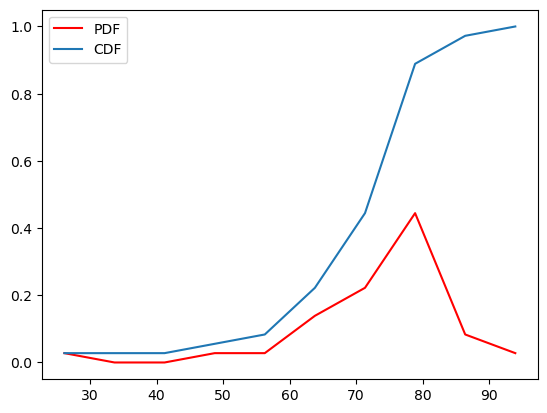

In [75]:
data_dsc_long = get_data('dsc', True)
print(data_dsc_long)
print(len(data_dsc_long))
plot_cdf(data_dsc_long, 10)

path:  ../optimizations/references/tracefiles_long
[87.31, 93.47, 77.6, 81.91, 81.66, 58.1, 74.47, 76.06, 70.45, 61.09, 67.2, 59.28, 65.23, 61.17, 64.43, 65.09, 64.69, 60.92, 90.15, 62.93, 66.42, 73.39, 75.74, 89.28, 57.65, 70.24, 76.31, 61.47, 57.94, 81.68, 83.59, 76.54, 77.22, 80.55, 83.51, 42.66, 74.1, 71.16, 71.55]
39


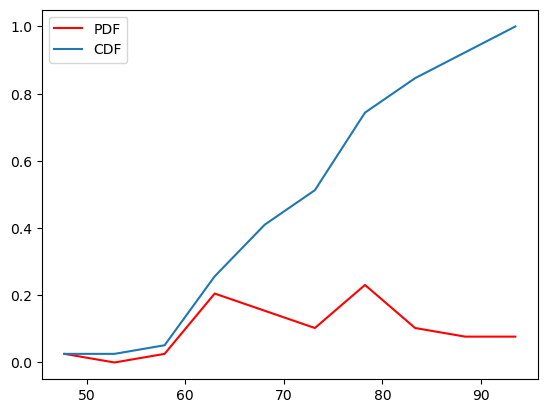

In [78]:
references_long = get_data('references', True)
print(references_long)
print(len(references_long))
plot_cdf(references_long, 10)

path:  ../optimizations/dsc-fused-operator/tracefiles_long
[82.98, 85.5, 81.24, 79.74, 76.74, 73.2, 66.11, 82.91, 65.22, 81.13, 79.97, 76.63, 73.14, 66.11, 71.18, 41.49, 93.91, 81.24, 79.74, 75.86, 72.71, 65.01, 81.13, 79.4, 79.63, 76.63, 73.2, 66.11, 18.67, 79.97, 77.84, 76.38, 73.11, 69.92, 61.82]
35


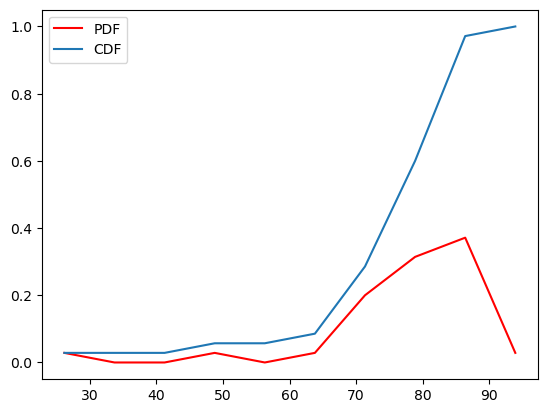

In [82]:
fused_long = get_data('dsc-fused-operator', True)
print(fused_long)
print(len(fused_long))
plot_cdf(fused_long, 10)